In [1]:
import scipy.io
import numpy as np
import pandas as pd
import os
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
meta_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"
train_annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"

### 1. LOAD CLASS NAMES

In [3]:
# 1. LOAD CLASS NAMES
meta = scipy.io.loadmat(meta_path)
raw_classes = meta['class_names'].flatten()
class_names = [i.item() for i in raw_classes]

print(class_names)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

### loading annotations

In [4]:
train_annos = scipy.io.loadmat(train_annos_path)
raw_annos = train_annos['annotations'][0]

print(raw_annos)

[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
 (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
 (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))
 ...
 (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9'))
 (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9'))
 (array([[20]], dtype=uint8), array([[240]], dtype=uint8), array([[862]], dtype=ui

## Building the dataframe

In [5]:
data = []
for sample in raw_annos:
    fname = sample['fname'].item()
    class_id = sample['class'].item()
    class_name = class_names[class_id - 1]
    
    # NEW: Extract Bounding Box Coordinates
    x1 = sample['bbox_x1'].item()
    y1 = sample['bbox_y1'].item()
    x2 = sample['bbox_x2'].item()
    y2 = sample['bbox_y2'].item()
    
    data.append([fname, class_id, class_name, x1, y1, x2, y2])

# Create DataFrame with new columns
df_train = pd.DataFrame(data, columns=['filename', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
print(f"Total Images: {len(df_train)}")
print(f"Total Classes: {len(class_names)}")
print(df_train.head())

Total Images: 8144
Total Classes: 196
    filename  class_id                           class_name   x1   y1    x2  \
0  00001.jpg        14                  Audi TTS Coupe 2012   39  116   569   
1  00002.jpg         3                  Acura TL Sedan 2012   36  116   868   
2  00003.jpg        91           Dodge Dakota Club Cab 2007   85  109   601   
3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012  621  393  1484   
4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   14   36   133   

     y2  
0   375  
1   587  
2   381  
3  1096  
4    99  


In [6]:
df_train['class_id'].value_counts()

class_id
119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: count, Length: 196, dtype: int64

In [7]:
df_train['filename'].max()

'08144.jpg'

## DataLoaders

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class StanfordCarsDataset(Dataset):

    def __init__(self , df ,root_dir , transform=None):

        self.df = df
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
      
        image = image.crop((row['x1'], row['y1'], row['x2'], row['y2']))
        
        # Get Label
        label = int(row['class_id']) - 1 
        
    
        if self.transform:
            image = self.transform(image)
            
        return image, label

## transformation and loader

In [9]:
# Some transformation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


images_root = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataframe: 70% Train, 15% testing ,15% Validation

train_df, test_df1 = train_test_split(
    df_train, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_train['class_id']
)


test_df , val_df = train_test_split(test_df1 , test_size = 0.5 , random_state=42 , stratify=test_df1['class_id'])

print(f"Training samples: {len(train_df)}")
print(f"Testing samples : {len(test_df)}")
print(f"Validation samples: {len(val_df)}")


# Train Loader
train_ds = StanfordCarsDataset(train_df, images_root, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)

# Validation Loader (Shuffle is False for validation usually)
val_ds = StanfordCarsDataset(val_df, images_root, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)


# Validation Loader (Shuffle is False for validation usually)
test_ds = StanfordCarsDataset(test_df, images_root, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Training samples: 5700
Testing samples : 1222
Validation samples: 1222


## building the model (Resnet50)

In [11]:
import torch.nn as nn
from torchvision import models 

# getting resnet
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


num_features = model.fc.in_features 

num_labels = len(df_train['class_id'].unique())

# Final layer
model.fc = nn.Linear(num_features, num_labels)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

print(f"Model ready for fine-tuning on {num_labels} classes.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Model ready for fine-tuning on 196 classes.


## Early stopping and ReduceLROnPlatue

In [12]:
import torch
import numpy as np

# A Helper Class for Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        patience: How many epochs to wait after last time validation loss improved.
        min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), 'best_checkpoint.pth')
        print(f'Validation loss decreased. Saving model...')

# --- SETUP OPTIMIZER & SCHEDULER ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Reduce LR by factor of 0.1 if val_loss doesn't improve for 2 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, verbose=True
)

# Stop completely if no improvement for 5 epochs
early_stopper = EarlyStopping(patience=5)

In [13]:
import torch.optim as optim
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()

## Custom Training loop

In [14]:

class training_loop:

    def __init__(self, num_epochs, model, train_loader, val_loader, device, criterion, optimizer, scheduler, early_stopper ):
        
        self.num_epochs = num_epochs
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.early_stopper = early_stopper


    
        self.train_loss_history = []
        self.val_loss_history   = []
        self.train_acc_history  = []
        self.val_acc_history    = []

    def train(self):
        """
        Main training execution method. 
        """
        
        for epoch in range(self.num_epochs):
            print(f"\n=== Epoch {epoch+1}/{self.num_epochs} ===")
            
            # --- TRAIN PHASE ---

            self.model = self.model.to(self.device)
            self.model.train()
            train_loss = 0
            train_correct = 0
            

    
            # TQDM for Training
            loop = tqdm(self.train_loader, desc="Training", leave=False)
            
            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                
                # Update progress bar
                loop.set_postfix(loss=loss.item())
                
            avg_train_loss = train_loss / len(self.train_loader.dataset)
            train_acc = train_correct / len(self.train_loader.dataset)
        
            # --- VALIDATION PHASE ---
            self.model.eval() # Disable dropout and batchnorm updates
            val_loss = 0
            val_correct = 0
            
            # No gradient needed for validation (saves memory and time)
            with torch.no_grad():
                for images, labels in self.val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    
                    val_loss += loss.item() * images.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    
            avg_val_loss = val_loss / len(self.val_loader.dataset)
            val_acc = val_correct / len(self.val_loader.dataset)
            
            # --- SAVE HISTORY ---
            # (Added this to ensure the __init__ lists are actually populated)
            self.train_loss_history.append(avg_train_loss)
            self.train_acc_history.append(train_acc)
            self.val_loss_history.append(avg_val_loss)
            self.val_acc_history.append(val_acc)

            # --- STATS & LOGIC ---
            print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
            
            # 1. Step the Scheduler (Adjust Learning Rate based on Val Loss)
            self.scheduler.step(avg_val_loss)
            
            # 2. Check Early Stopping
            self.early_stopper(avg_val_loss, self.model)
            
            if self.early_stopper.early_stop:
                print("Early stopping triggered! Training finished.")
                break
        
        print("Training Complete.")
        return self.model, {
            'train_loss': self.train_loss_history,
            'val_loss': self.val_loss_history,
            'train_acc': self.train_acc_history,
            'val_acc': self.val_acc_history
        }

In [15]:
trainer = training_loop(
    num_epochs=20,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopper=early_stopper
)

trained_model, history = trainer.train()


=== Epoch 1/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.7933 | Train Acc: 0.0830
Val Loss:   3.4149 | Val Acc:   0.2758
Validation loss decreased. Saving model...

=== Epoch 2/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.3685 | Train Acc: 0.5309
Val Loss:   1.5643 | Val Acc:   0.6391
Validation loss decreased. Saving model...

=== Epoch 3/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.9079 | Train Acc: 0.8212
Val Loss:   0.9038 | Val Acc:   0.7700
Validation loss decreased. Saving model...

=== Epoch 4/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3976 | Train Acc: 0.9218
Val Loss:   0.7282 | Val Acc:   0.8183
Validation loss decreased. Saving model...

=== Epoch 5/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1932 | Train Acc: 0.9686
Val Loss:   0.6536 | Val Acc:   0.8232
Validation loss decreased. Saving model...

=== Epoch 6/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1115 | Train Acc: 0.9826
Val Loss:   0.5863 | Val Acc:   0.8412
Validation loss decreased. Saving model...

=== Epoch 7/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0754 | Train Acc: 0.9895
Val Loss:   0.6374 | Val Acc:   0.8290
EarlyStopping counter: 1 out of 5

=== Epoch 8/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0507 | Train Acc: 0.9933
Val Loss:   0.5811 | Val Acc:   0.8388
Validation loss decreased. Saving model...

=== Epoch 9/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0362 | Train Acc: 0.9954
Val Loss:   0.5822 | Val Acc:   0.8560
EarlyStopping counter: 1 out of 5

=== Epoch 10/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0378 | Train Acc: 0.9946
Val Loss:   0.5961 | Val Acc:   0.8478
EarlyStopping counter: 2 out of 5

=== Epoch 11/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0341 | Train Acc: 0.9958
Val Loss:   0.5381 | Val Acc:   0.8592
Validation loss decreased. Saving model...

=== Epoch 12/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0267 | Train Acc: 0.9960
Val Loss:   0.5695 | Val Acc:   0.8543
EarlyStopping counter: 1 out of 5

=== Epoch 13/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0294 | Train Acc: 0.9970
Val Loss:   0.5758 | Val Acc:   0.8511
EarlyStopping counter: 2 out of 5

=== Epoch 14/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0170 | Train Acc: 0.9975
Val Loss:   0.6089 | Val Acc:   0.8470
EarlyStopping counter: 3 out of 5

=== Epoch 15/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0104 | Train Acc: 0.9989
Val Loss:   0.5773 | Val Acc:   0.8568
EarlyStopping counter: 4 out of 5

=== Epoch 16/20 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0077 | Train Acc: 0.9993
Val Loss:   0.5777 | Val Acc:   0.8625
EarlyStopping counter: 5 out of 5
Early stopping triggered! Training finished.
Training Complete.


In [16]:
def evaluate_model(model, loader, device):
    model.eval()
    
    correct_1 = 0
    correct_5 = 0
    total = 0
    
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # --- Top-1 Accuracy ---
            _, pred_1 = torch.max(outputs, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # --- Top-5 Accuracy ---
            _, pred_5 = outputs.topk(5, 1, largest=True, sorted=True)
            
            # Check if true label is in the top 5 predictions
            # labels.view(-1, 1) reshapes labels to [Batch, 1] to broadcast against [Batch, 5]
            correct_5 += (pred_5 == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
            
            # Store for detailed report
            all_preds.extend(pred_1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    top1_acc = correct_1 / total
    top5_acc = correct_5 / total
    
    return top1_acc, top5_acc, all_labels, all_preds


device = torch.device("cuda")
model.load_state_dict(torch.load('best_checkpoint.pth'))
acc_1, acc_5, y_true, y_pred = evaluate_model(model, test_loader, device)

print("-" * 30)
print(f"Top-1 Accuracy: {acc_1*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5*100:.2f}%")
print("-" * 30)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

------------------------------
Top-1 Accuracy: 85.60%
Top-5 Accuracy: 96.64%
------------------------------


In [17]:
from sklearn.metrics import classification_report

# We pass the class names list so the report uses names instead of numbers
# Note: Ensure class_names len matches the unique classes in test set
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8000    0.5714    0.6667         7
                                   Acura RL Sedan 2012     0.6667    0.4000    0.5000         5
                                   Acura TL Sedan 2012     1.0000    1.0000    1.0000         6
                                  Acura TL Type-S 2008     1.0000    0.8333    0.9091         6
                                  Acura TSX Sedan 2012     0.8571    1.0000    0.9231         6
                             Acura Integra Type R 2001     0.8333    0.8333    0.8333         6
                              Acura ZDX Hatchback 2012     0.8571    1.0000    0.9231         6
              Aston Martin V8 Vantage Convertible 2012     0.5000    0.5714    0.5333         7
                    Aston Martin V8 Vantage Coupe 2012     0.3333    0.1667    0.2222         6
                  Aston Martin Virage C

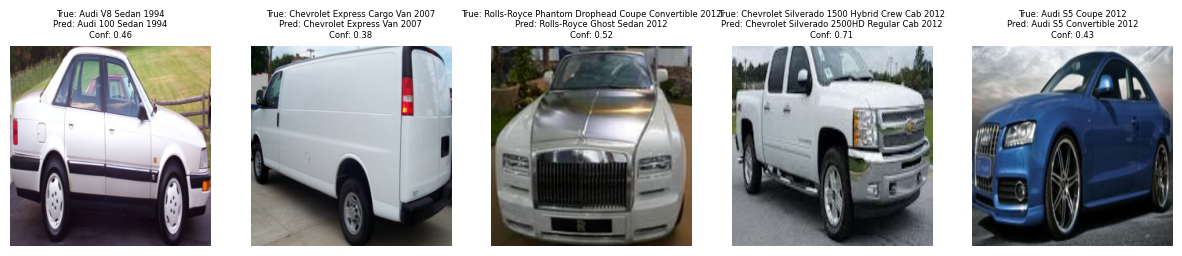

In [18]:
import matplotlib.pyplot as plt

def visualize_failures(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs, preds = torch.max(torch.softmax(outputs, dim=1), 1)
            
            for i in range(len(images)):
                if preds[i] != labels[i]: # If WRONG
                    if images_shown >= num_images: return
                    
                    # Undo normalization for plotting
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                    img = np.clip(img, 0, 1)
                    
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]
                    confidence = probs[i].item()
                    
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", fontsize=6, color='black')
                    plt.axis('off')
                    
                    images_shown += 1

visualize_failures(model, test_loader, device)

## VGG-19 from scratch

In [19]:
import torch
import torch.nn as nn


class VGG19FromScratch(nn.Module):

    def __init__(self , num_classes , in_channels=3):
        super().__init__()

        self.conv_layers = nn.Sequential(

            #1st block
            nn.Conv2d(in_channels=in_channels , out_channels= 64 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64 , out_channels= 64 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            #2nd block

            nn.Conv2d(in_channels=64 , out_channels= 128 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128 , out_channels= 128 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            #3rd block

            nn.Conv2d(in_channels=128 , out_channels= 256 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256 , out_channels= 256 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256 , out_channels= 256 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256 , out_channels= 256 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            #4th block

            nn.Conv2d(in_channels=256 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            #5th
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512 , out_channels= 512 , padding=1 , kernel_size = (3,3) , stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),
        )

        # classifier
        self.classifier =  nn.Sequential(   
            nn.Linear(512*7*7 , 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)
        )

      # Apply He (Kaiming) initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He initialization for Conv layers (fan_out mode is better for ReLU)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # He initialization for Linear layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)


    def forward(self , input):

        x = self.conv_layers(input)
        x = torch.flatten(x , 1)
        logits = self.classifier(x)

        return logits

In [20]:
# Some transformation
train_transforms_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



# Train Loader
train_ds_vgg = StanfordCarsDataset(train_df, images_root, transform=train_transforms_vgg)
train_loader_vgg = DataLoader(train_ds_vgg, batch_size=32, shuffle=True, num_workers=0)

# Validation Loader (Shuffle is False for validation usually)
val_ds_vgg = StanfordCarsDataset(val_df, images_root, transform=train_transforms_vgg)
val_loader_vgg = DataLoader(val_ds_vgg, batch_size=32, shuffle=False, num_workers=0)


# Validation Loader (Shuffle is False for validation usually)
test_ds_vgg = StanfordCarsDataset(test_df, images_root, transform=test_transforms_vgg)
test_loader_vgg = DataLoader(test_ds_vgg, batch_size=32, shuffle=False, num_workers=0)

In [21]:
vgg_model = VGG19FromScratch(num_labels)



optimizer_vgg = torch.optim.Adam(vgg_model.parameters(), lr=1e-2)

# Reduce LR by factor of 0.1 if val_loss doesn't improve for 2 epochs
scheduler_vgg = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vgg, mode='min', factor=0.1, patience=2, verbose=True
)


early_stopper_vgg = EarlyStopping(patience=5)

trainer_vgg = training_loop(
    num_epochs=74,
    model=vgg_model,
    train_loader=train_loader_vgg,
    val_loader=val_loader_vgg,
    device=device,
    criterion=criterion,
    optimizer=optimizer_vgg,
    scheduler=scheduler_vgg,
    early_stopper=early_stopper_vgg
)

trained_model_vgg , history_vgg = trainer_vgg.train()


=== Epoch 1/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 52599970173.6366 | Train Acc: 0.0054
Val Loss:   9.4854 | Val Acc:   0.0057
Validation loss decreased. Saving model...

=== Epoch 2/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.3084 | Train Acc: 0.0074
Val Loss:   6.2049 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 3/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2825 | Train Acc: 0.0081
Val Loss:   6.2035 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 4/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 15173713.3403 | Train Acc: 0.0070
Val Loss:   5.2933 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 5/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2885 | Train Acc: 0.0089
Val Loss:   5.2743 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 6/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2824 | Train Acc: 0.0084
Val Loss:   5.2738 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 7/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2821 | Train Acc: 0.0084
Val Loss:   5.2735 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 8/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2824 | Train Acc: 0.0084
Val Loss:   5.2734 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 9/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2819 | Train Acc: 0.0084
Val Loss:   5.2731 | Val Acc:   0.0082
Validation loss decreased. Saving model...

=== Epoch 10/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2822 | Train Acc: 0.0084
Val Loss:   5.2733 | Val Acc:   0.0082
EarlyStopping counter: 1 out of 5

=== Epoch 11/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2826 | Train Acc: 0.0084
Val Loss:   5.2734 | Val Acc:   0.0082
EarlyStopping counter: 2 out of 5

=== Epoch 12/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2828 | Train Acc: 0.0084
Val Loss:   5.2736 | Val Acc:   0.0082
EarlyStopping counter: 3 out of 5

=== Epoch 13/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2740 | Train Acc: 0.0084
Val Loss:   5.2735 | Val Acc:   0.0082
EarlyStopping counter: 4 out of 5

=== Epoch 14/74 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2739 | Train Acc: 0.0084
Val Loss:   5.2734 | Val Acc:   0.0082
EarlyStopping counter: 5 out of 5
Early stopping triggered! Training finished.
Training Complete.


In [22]:
acc_1_vgg, acc_5_vgg, y_true_vgg, y_pred_vgg = evaluate_model(vgg_model, test_loader_vgg, device)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

In [23]:
print("-" * 30)
print(f"Top-1 Accuracy: {acc_1_vgg*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5_vgg*100:.2f}%")
print("-" * 30)

------------------------------
Top-1 Accuracy: 0.82%
Top-5 Accuracy: 3.11%
------------------------------


In [24]:
from sklearn.metrics import classification_report

# We pass the class names list so the report uses names instead of numbers
# Note: Ensure class_names len matches the unique classes in test set
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names, digits=4))

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.0000    0.0000    0.0000         7
                                   Acura RL Sedan 2012     0.0000    0.0000    0.0000         5
                                   Acura TL Sedan 2012     0.0000    0.0000    0.0000         6
                                  Acura TL Type-S 2008     0.0000    0.0000    0.0000         6
                                  Acura TSX Sedan 2012     0.0000    0.0000    0.0000         6
                             Acura Integra Type R 2001     0.0000    0.0000    0.0000         6
                              Acura ZDX Hatchback 2012     0.0000    0.0000    0.0000         6
              Aston Martin V8 Vantage Convertible 2012     0.0000    0.0000    0.0000         7
                    Aston Martin V8 Vantage Coupe 2012     0.0000    0.0000    0.0000         6
                  Aston Martin Virage C

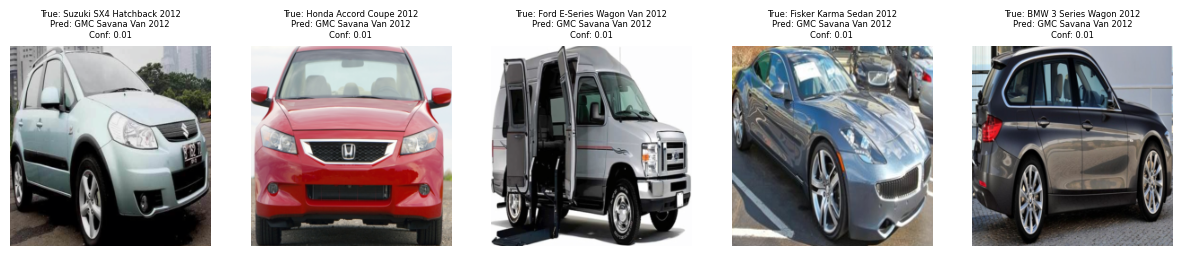

In [25]:
visualize_failures(vgg_model , test_loader_vgg , device)

## Metrics and Comparisons

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_fscore_support,
    top_k_accuracy_score, log_loss
)
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

In [27]:
def get_predictions_and_probabilities(model, loader, device, num_classes):
    """
    Get predictions, true labels, and probability scores for a model.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting predictions"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities using softmax
            probs = F.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


def compute_metrics(y_true, y_pred, y_probs, num_classes, model_name="Model"):
    """
    Compute comprehensive metrics for a model.
    """
    metrics = {}
    
    # Basic metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1
    
    # Top-1 and Top-5 Accuracy
    metrics['top1_accuracy'] = (y_pred == y_true).mean()
    metrics['top5_accuracy'] = top_k_accuracy_score(y_true, y_probs, k=5)
    
    # Log Loss (Cross-Entropy)
    metrics['log_loss'] = log_loss(y_true, y_probs)
    
    # AUC-ROC (One-vs-Rest for multiclass)
    try:
        # Binarize labels for multiclass ROC-AUC
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        # Macro-average AUC-ROC
        metrics['auc_roc_macro'] = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
        
        # Weighted-average AUC-ROC
        metrics['auc_roc_weighted'] = roc_auc_score(y_true_bin, y_probs, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"Could not compute AUC-ROC: {e}")
        metrics['auc_roc_macro'] = None
        metrics['auc_roc_weighted'] = None
    
    print(f"\n{'='*50}")
    print(f"Metrics for {model_name}")
    print(f"{'='*50}")
    print(f"Top-1 Accuracy:     {metrics['top1_accuracy']*100:.2f}%")
    print(f"Top-5 Accuracy:     {metrics['top5_accuracy']*100:.2f}%")
    print(f"Precision:          {metrics['precision']*100:.2f}%")
    print(f"Recall:             {metrics['recall']*100:.2f}%")
    print(f"F1-Score:           {metrics['f1_score']*100:.2f}%")
    print(f"Log Loss:           {metrics['log_loss']:.4f}")
    if metrics['auc_roc_macro']:
        print(f"AUC-ROC (Macro):    {metrics['auc_roc_macro']:.4f}")
        print(f"AUC-ROC (Weighted): {metrics['auc_roc_weighted']:.4f}")
    print(f"{'='*50}")
    
    return metrics

In [28]:
# Evaluate ResNet50 Model
print("Evaluating ResNet50...")
# model.load_state_dict(torch.load('best_checkpoint.pth'))
model = model.to(device)

y_true_resnet, y_pred_resnet, y_probs_resnet = get_predictions_and_probabilities(
    model, test_loader, device, num_labels
)
metrics_resnet = compute_metrics(y_true_resnet, y_pred_resnet, y_probs_resnet, num_labels, "ResNet50")

# Evaluate VGG19 Model
print("\nEvaluating VGG19...")
# vgg_model.load_state_dict(torch.load('best_checkpoint_vgg.pth'))
vgg_model = vgg_model.to(device)

y_true_vgg, y_pred_vgg, y_probs_vgg = get_predictions_and_probabilities(
    vgg_model, test_loader_vgg, device, num_labels
)
metrics_vgg = compute_metrics(y_true_vgg, y_pred_vgg, y_probs_vgg, num_labels, "VGG19")

Evaluating ResNet50...


Getting predictions:   0%|          | 0/39 [00:00<?, ?it/s]


Metrics for ResNet50
Top-1 Accuracy:     85.60%
Top-5 Accuracy:     96.64%
Precision:          86.88%
Recall:             85.60%
F1-Score:           85.32%
Log Loss:           0.5033
AUC-ROC (Macro):    0.9986
AUC-ROC (Weighted): 0.9986

Evaluating VGG19...


Getting predictions:   0%|          | 0/39 [00:00<?, ?it/s]


Metrics for VGG19
Top-1 Accuracy:     0.82%
Top-5 Accuracy:     3.11%
Precision:          0.01%
Recall:             0.82%
F1-Score:           0.01%
Log Loss:           5.2726
AUC-ROC (Macro):    0.5000
AUC-ROC (Weighted): 0.5000


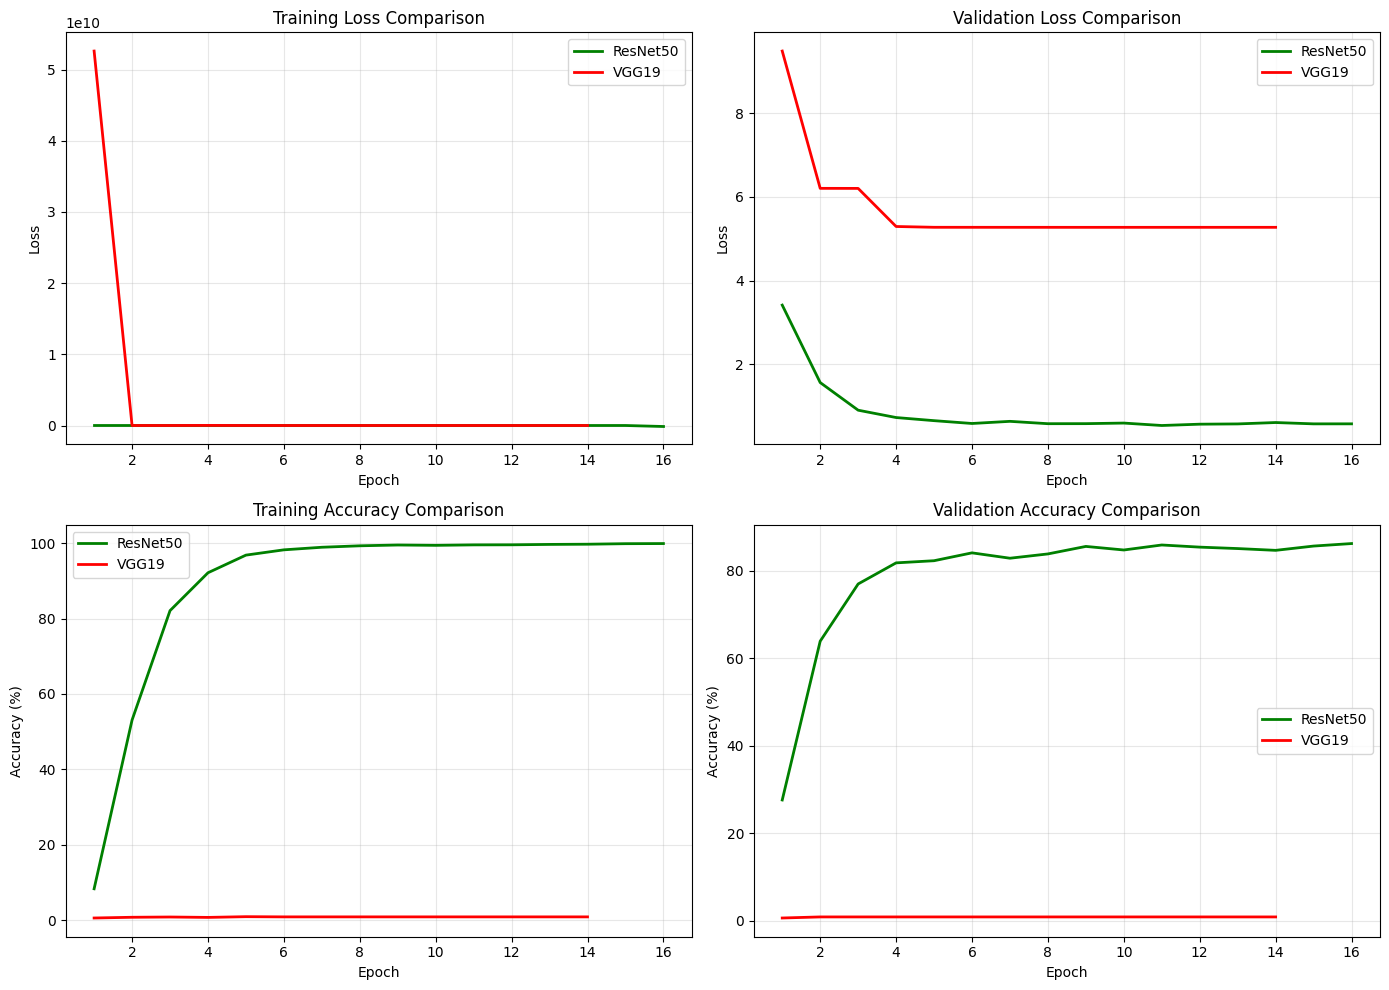

In [29]:
# Training History Comparison (Loss and Accuracy curves)
def plot_training_history_comparison(history_resnet, history_vgg):
    """
    Plot training/validation loss and accuracy curves for both models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    epochs_resnet = range(1, len(history_resnet['train_loss']) + 1)
    epochs_vgg = range(1, len(history_vgg['train_loss']) + 1)
    
    # --- Training Loss ---
    axes[0, 0].plot(epochs_resnet, history_resnet['train_loss'], 'g-', linewidth=2, label='ResNet50')
    axes[0, 0].plot(epochs_vgg, history_vgg['train_loss'], 'r-', linewidth=2, label='VGG19')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # --- Validation Loss ---
    axes[0, 1].plot(epochs_resnet, history_resnet['val_loss'], 'g-', linewidth=2, label='ResNet50')
    axes[0, 1].plot(epochs_vgg, history_vgg['val_loss'], 'r-', linewidth=2, label='VGG19')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Validation Loss Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # --- Training Accuracy ---
    axes[1, 0].plot(epochs_resnet, [acc * 100 for acc in history_resnet['train_acc']], 'g-', linewidth=2, label='ResNet50')
    axes[1, 0].plot(epochs_vgg, [acc * 100 for acc in history_vgg['train_acc']], 'r-', linewidth=2, label='VGG19')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # --- Validation Accuracy ---
    axes[1, 1].plot(epochs_resnet, [acc * 100 for acc in history_resnet['val_acc']], 'g-', linewidth=2, label='ResNet50')
    axes[1, 1].plot(epochs_vgg, [acc * 100 for acc in history_vgg['val_acc']], 'r-', linewidth=2, label='VGG19')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Validation Accuracy Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Use the history dictionaries from training
plot_training_history_comparison(history, history_vgg)

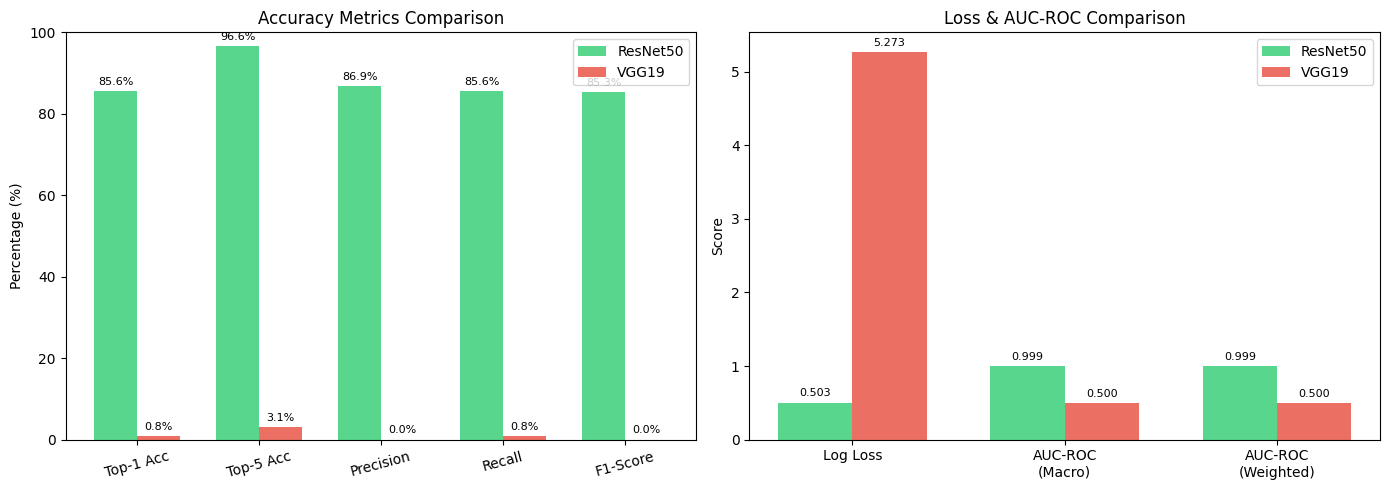

In [30]:
# Metrics Comparison Bar Chart
def plot_metrics_comparison(metrics_resnet, metrics_vgg):
    """
    Create a bar chart comparing metrics between two models.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy metrics comparison
    accuracy_metrics = ['top1_accuracy', 'top5_accuracy', 'precision', 'recall', 'f1_score']
    accuracy_labels = ['Top-1 Acc', 'Top-5 Acc', 'Precision', 'Recall', 'F1-Score']
    
    resnet_values = [metrics_resnet[m] * 100 for m in accuracy_metrics]
    vgg_values = [metrics_vgg[m] * 100 for m in accuracy_metrics]
    
    x = np.arange(len(accuracy_labels))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, resnet_values, width, label='ResNet50', color='#2ecc71', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, vgg_values, width, label='VGG19', color='#e74c3c', alpha=0.8)
    
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_title('Accuracy Metrics Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(accuracy_labels, rotation=15)
    axes[0].legend()
    axes[0].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # Loss and AUC comparison
    other_metrics = ['log_loss', 'auc_roc_macro', 'auc_roc_weighted']
    other_labels = ['Log Loss', 'AUC-ROC\n(Macro)', 'AUC-ROC\n(Weighted)']
    
    resnet_other = [metrics_resnet[m] if metrics_resnet[m] else 0 for m in other_metrics]
    vgg_other = [metrics_vgg[m] if metrics_vgg[m] else 0 for m in other_metrics]
    
    x2 = np.arange(len(other_labels))
    
    bars3 = axes[1].bar(x2 - width/2, resnet_other, width, label='ResNet50', color='#2ecc71', alpha=0.8)
    bars4 = axes[1].bar(x2 + width/2, vgg_other, width, label='VGG19', color='#e74c3c', alpha=0.8)
    
    axes[1].set_ylabel('Score')
    axes[1].set_title('Loss & AUC-ROC Comparison')
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(other_labels)
    axes[1].legend()
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    for bar in bars4:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(metrics_resnet, metrics_vgg)

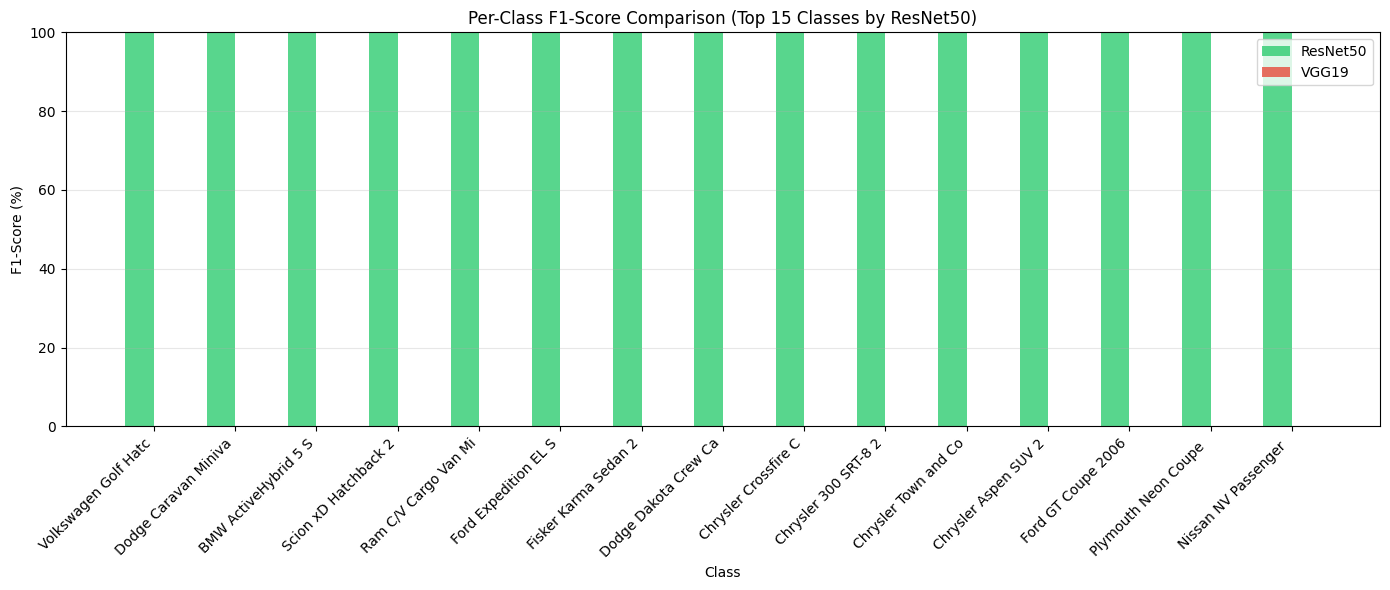

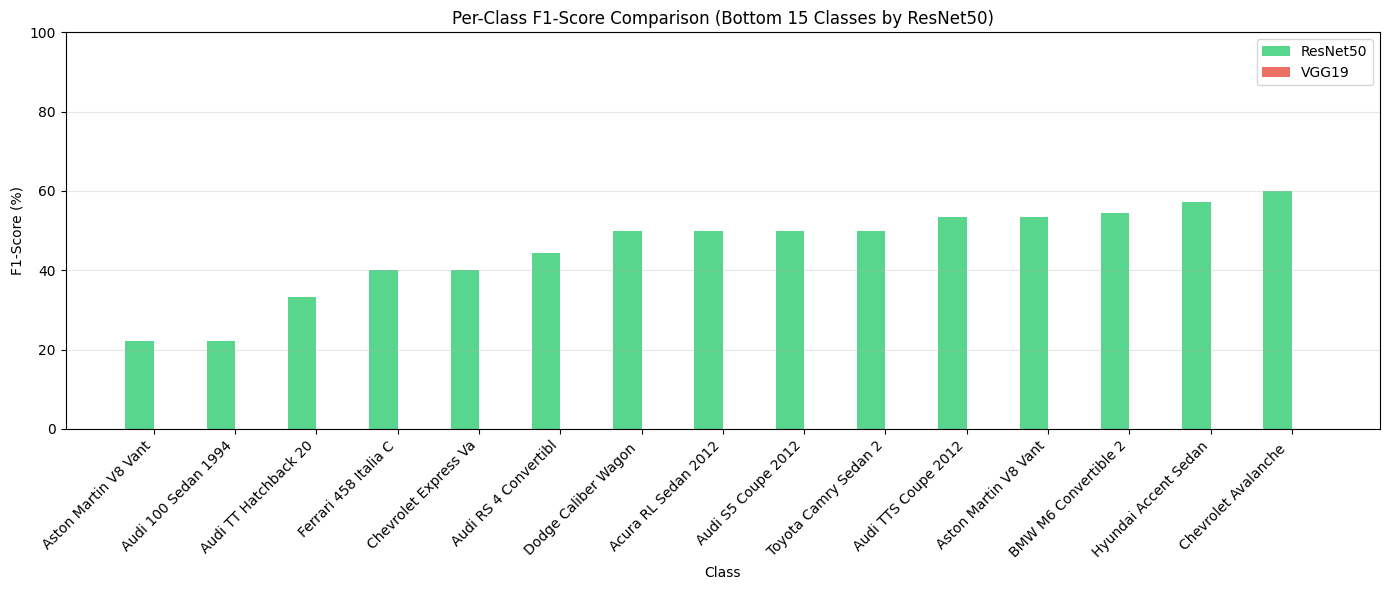

In [31]:
# Per-Class Performance Comparison
def plot_per_class_performance(y_true_resnet, y_pred_resnet, y_true_vgg, y_pred_vgg, class_names, top_n=15):
    """
    Compare per-class F1 scores between models.
    """
    from sklearn.metrics import f1_score
    
    # Calculate per-class F1 scores
    f1_resnet = precision_recall_fscore_support(y_true_resnet, y_pred_resnet, average=None)[2]
    f1_vgg = precision_recall_fscore_support(y_true_vgg, y_pred_vgg, average=None)[2]
    
    # Get top N classes by ResNet performance for comparison
    top_indices = np.argsort(f1_resnet)[-top_n:][::-1]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(top_n)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, f1_resnet[top_indices] * 100, width, label='ResNet50', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_vgg[top_indices] * 100, width, label='VGG19', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('F1-Score (%)')
    ax.set_title(f'Per-Class F1-Score Comparison (Top {top_n} Classes by ResNet50)')
    ax.set_xticks(x)
    ax.set_xticklabels([class_names[i][:20] for i in top_indices], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Also show worst performing classes
    fig, ax = plt.subplots(figsize=(14, 6))
    
    worst_indices = np.argsort(f1_resnet)[:top_n]
    
    bars1 = ax.bar(x - width/2, f1_resnet[worst_indices] * 100, width, label='ResNet50', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_vgg[worst_indices] * 100, width, label='VGG19', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('F1-Score (%)')
    ax.set_title(f'Per-Class F1-Score Comparison (Bottom {top_n} Classes by ResNet50)')
    ax.set_xticks(x)
    ax.set_xticklabels([class_names[i][:20] for i in worst_indices], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_per_class_performance(y_true_resnet, y_pred_resnet, y_true_vgg, y_pred_vgg, class_names)

In [32]:
# Summary Table
def create_summary_table(metrics_resnet, metrics_vgg):
    """
    Create a summary DataFrame comparing both models.
    """
    summary_data = {
        'Metric': [
            'Top-1 Accuracy (%)',
            'Top-5 Accuracy (%)',
            'Precision (%)',
            'Recall (%)',
            'F1-Score (%)',
            'Log Loss',
            'AUC-ROC (Macro)',
            'AUC-ROC (Weighted)'
        ],
        'ResNet50': [
            f"{metrics_resnet['top1_accuracy']*100:.2f}",
            f"{metrics_resnet['top5_accuracy']*100:.2f}",
            f"{metrics_resnet['precision']*100:.2f}",
            f"{metrics_resnet['recall']*100:.2f}",
            f"{metrics_resnet['f1_score']*100:.2f}",
            f"{metrics_resnet['log_loss']:.4f}",
            f"{metrics_resnet['auc_roc_macro']:.4f}" if metrics_resnet['auc_roc_macro'] else "N/A",
            f"{metrics_resnet['auc_roc_weighted']:.4f}" if metrics_resnet['auc_roc_weighted'] else "N/A"
        ],
        'VGG19': [
            f"{metrics_vgg['top1_accuracy']*100:.2f}",
            f"{metrics_vgg['top5_accuracy']*100:.2f}",
            f"{metrics_vgg['precision']*100:.2f}",
            f"{metrics_vgg['recall']*100:.2f}",
            f"{metrics_vgg['f1_score']*100:.2f}",
            f"{metrics_vgg['log_loss']:.4f}",
            f"{metrics_vgg['auc_roc_macro']:.4f}" if metrics_vgg['auc_roc_macro'] else "N/A",
            f"{metrics_vgg['auc_roc_weighted']:.4f}" if metrics_vgg['auc_roc_weighted'] else "N/A"
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    
    # Add a "Winner" column
    winners = []
    for i, metric in enumerate(summary_data['Metric']):
        try:
            resnet_val = float(summary_data['ResNet50'][i])
            vgg_val = float(summary_data['VGG19'][i])
            
            if 'Loss' in metric:  # Lower is better for loss
                winners.append('ResNet50' if resnet_val < vgg_val else 'VGG19')
            else:  # Higher is better for accuracy metrics
                winners.append('ResNet50' if resnet_val > vgg_val else 'VGG19')
        except:
            winners.append('N/A')
    
    df_summary['Winner'] = winners
    
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    print(df_summary.to_string(index=False))
    print("="*70)
    
    return df_summary

summary_df = create_summary_table(metrics_resnet, metrics_vgg)
summary_df


MODEL COMPARISON SUMMARY
            Metric ResNet50  VGG19   Winner
Top-1 Accuracy (%)    85.60   0.82 ResNet50
Top-5 Accuracy (%)    96.64   3.11 ResNet50
     Precision (%)    86.88   0.01 ResNet50
        Recall (%)    85.60   0.82 ResNet50
      F1-Score (%)    85.32   0.01 ResNet50
          Log Loss   0.5033 5.2726 ResNet50
   AUC-ROC (Macro)   0.9986 0.5000 ResNet50
AUC-ROC (Weighted)   0.9986 0.5000 ResNet50


,Metric,ResNet50,VGG19,Winner
0,Top-1 Accuracy (%),85.60,0.82,ResNet50
1,Top-5 Accuracy (%),96.64,3.11,ResNet50
2,Precision (%),86.88,0.01,ResNet50
3,Recall (%),85.60,0.82,ResNet50
4,F1-Score (%),85.32,0.01,ResNet50
5,Log Loss,0.5033,5.2726,ResNet50
6,AUC-ROC (Macro),0.9986,0.5000,ResNet50
7,AUC-ROC (Weighted),0.9986,0.5000,ResNet50


## ROC Curves and AUC Comparison

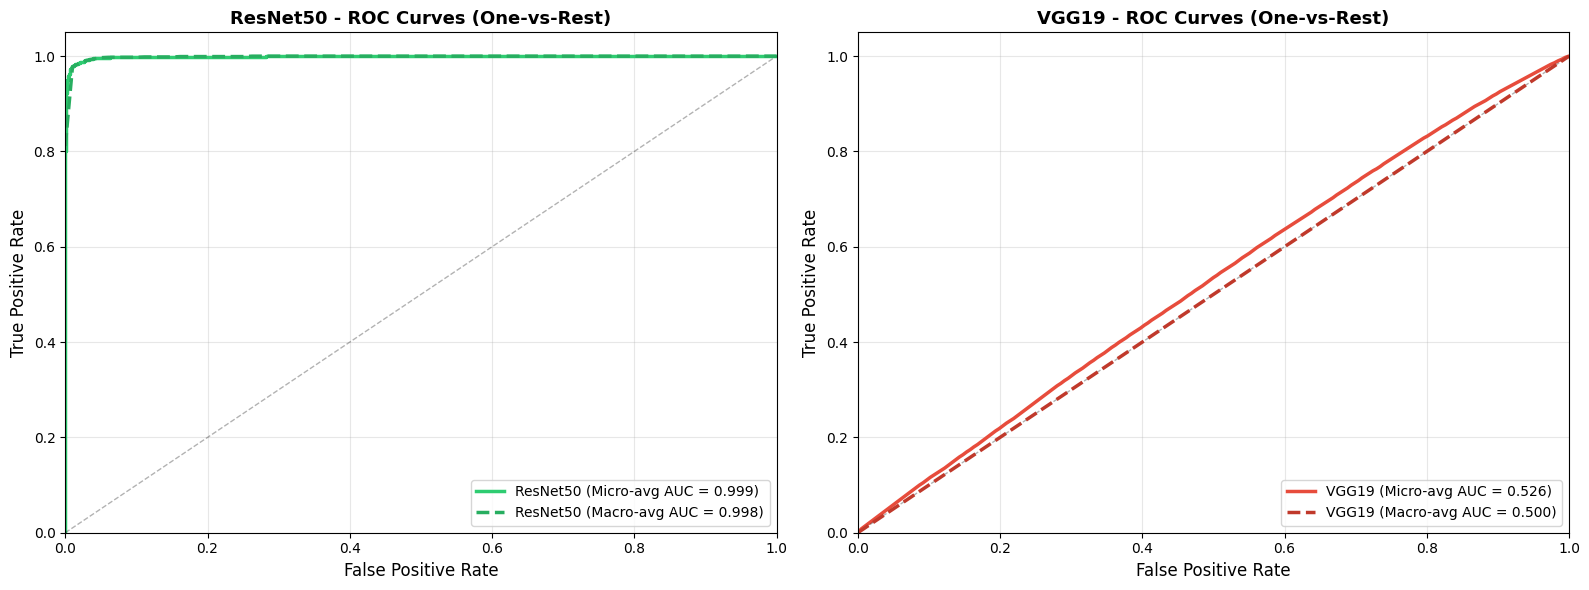

ROC Curves plotted successfully!


In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves_multiclass(y_true, y_probs, model_name, num_classes, ax, colors):
    """
    Plot ROC curves for One-vs-Rest multiclass classification.
    """
    # Binarize the labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot the micro-average ROC curve
    ax.plot(fpr["micro"], tpr["micro"], color=colors[0], lw=2.5,
            label=f'{model_name} (Micro-avg AUC = {roc_auc["micro"]:.3f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    
    # Compute macro-average ROC curve
    fpr_macro = np.linspace(0, 1, 100)
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(num_classes):
        tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= num_classes
    
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    ax.plot(fpr_macro, tpr_macro, color=colors[1], lw=2.5, linestyle='--',
            label=f'{model_name} (Macro-avg AUC = {roc_auc_macro:.3f})')
    
    return roc_auc

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ResNet50 ROC Curve
roc_auc_resnet = plot_roc_curves_multiclass(
    y_true_resnet, y_probs_resnet, 'ResNet50', num_labels, 
    axes[0], ['#2ecc71', '#27ae60']
)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ResNet50 - ROC Curves (One-vs-Rest)', fontsize=13, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(True, alpha=0.3)

# VGG19 ROC Curve
roc_auc_vgg = plot_roc_curves_multiclass(
    y_true_vgg, y_probs_vgg, 'VGG19', num_labels, 
    axes[1], ['#e74c3c', '#c0392b']
)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('VGG19 - ROC Curves (One-vs-Rest)', fontsize=13, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ROC Curves plotted successfully!")

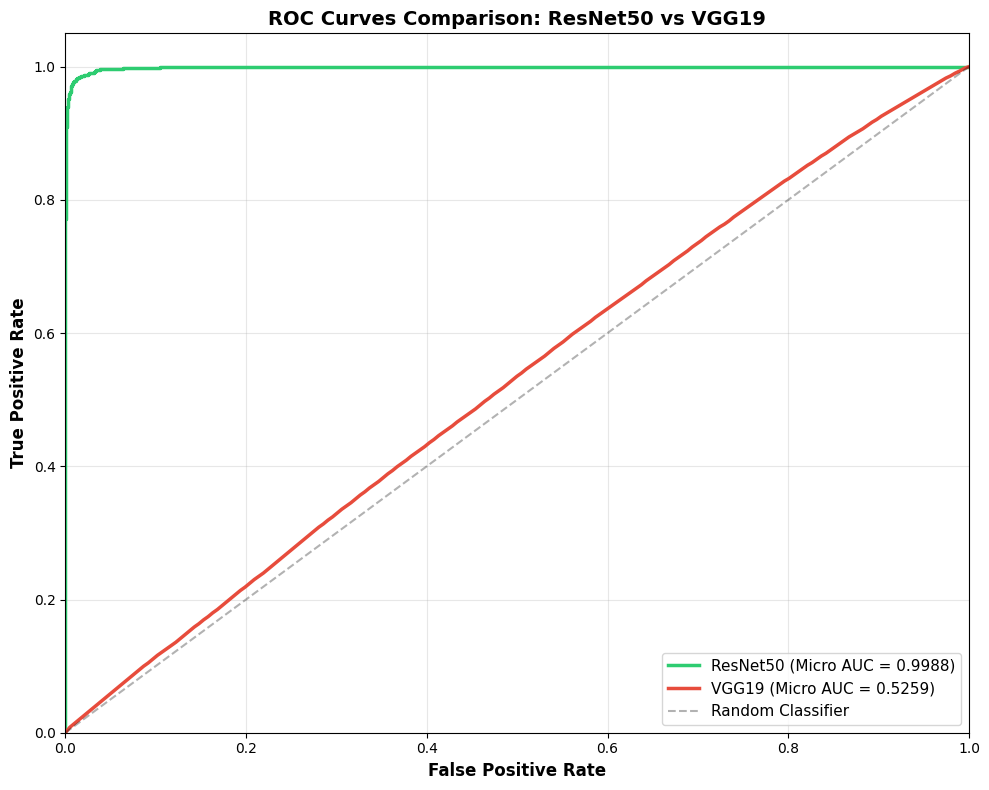


ROC AUC Comparison (Micro-Average):
ResNet50 AUC: 0.9988
VGG19 AUC:    0.5259
Difference:   0.4728


In [34]:
# Combined ROC Curves Comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Binarize labels for both models
y_true_bin_resnet = label_binarize(y_true_resnet, classes=range(num_labels))
y_true_bin_vgg = label_binarize(y_true_vgg, classes=range(num_labels))

# Compute micro-average ROC for ResNet50
fpr_resnet_micro, tpr_resnet_micro, _ = roc_curve(y_true_bin_resnet.ravel(), y_probs_resnet.ravel())
roc_auc_resnet_micro = auc(fpr_resnet_micro, tpr_resnet_micro)

# Compute micro-average ROC for VGG19
fpr_vgg_micro, tpr_vgg_micro, _ = roc_curve(y_true_bin_vgg.ravel(), y_probs_vgg.ravel())
roc_auc_vgg_micro = auc(fpr_vgg_micro, tpr_vgg_micro)

# Plot both curves
ax.plot(fpr_resnet_micro, tpr_resnet_micro, color='#2ecc71', lw=2.5, 
        label=f'ResNet50 (Micro AUC = {roc_auc_resnet_micro:.4f})')
ax.plot(fpr_vgg_micro, tpr_vgg_micro, color='#e74c3c', lw=2.5,
        label=f'VGG19 (Micro AUC = {roc_auc_vgg_micro:.4f})')

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison: ResNet50 vs VGG19', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nROC AUC Comparison (Micro-Average):")
print(f"{'='*40}")
print(f"ResNet50 AUC: {roc_auc_resnet_micro:.4f}")
print(f"VGG19 AUC:    {roc_auc_vgg_micro:.4f}")
print(f"Difference:   {abs(roc_auc_resnet_micro - roc_auc_vgg_micro):.4f}")
print(f"{'='*40}")

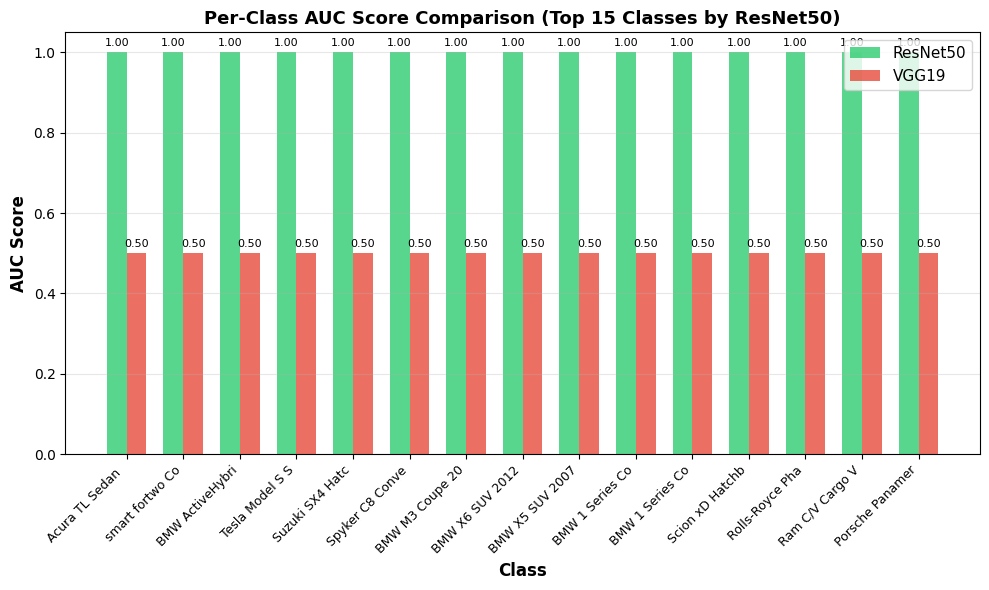


Per-Class AUC Statistics:
ResNet50 - Mean AUC: 0.9986 ± 0.0042
VGG19    - Mean AUC: 0.5000 ± 0.0000


In [35]:
# AUC Score Bar Chart Comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Compute AUC scores for each class
y_true_bin_resnet = label_binarize(y_true_resnet, classes=range(num_labels))
y_true_bin_vgg = label_binarize(y_true_vgg, classes=range(num_labels))

auc_scores_resnet = []
auc_scores_vgg = []
class_indices = []

for i in range(num_labels):
    # ResNet50
    fpr_r, tpr_r, _ = roc_curve(y_true_bin_resnet[:, i], y_probs_resnet[:, i])
    auc_r = auc(fpr_r, tpr_r)
    auc_scores_resnet.append(auc_r)
    
    # VGG19
    fpr_v, tpr_v, _ = roc_curve(y_true_bin_vgg[:, i], y_probs_vgg[:, i])
    auc_v = auc(fpr_v, tpr_v)
    auc_scores_vgg.append(auc_v)
    
    class_indices.append(i)

# Get top 15 classes by ResNet50 AUC for better visualization
top_indices = np.argsort(auc_scores_resnet)[-15:][::-1]

x = np.arange(len(top_indices))
width = 0.35

bars1 = ax.bar(x - width/2, [auc_scores_resnet[i] for i in top_indices], width, 
               label='ResNet50', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, [auc_scores_vgg[i] for i in top_indices], width,
               label='VGG19', color='#e74c3c', alpha=0.8)

ax.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_title('Per-Class AUC Score Comparison (Top 15 Classes by ResNet50)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([class_names[i][:15] for i in top_indices], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nPer-Class AUC Statistics:")
print(f"{'='*50}")
print(f"ResNet50 - Mean AUC: {np.mean(auc_scores_resnet):.4f} ± {np.std(auc_scores_resnet):.4f}")
print(f"VGG19    - Mean AUC: {np.mean(auc_scores_vgg):.4f} ± {np.std(auc_scores_vgg):.4f}")
print(f"{'='*50}")
